In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import statsmodels.api as sm
from scipy import stats
from scipy.stats import chi2_contingency
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind
from scipy.stats import pearsonr


In [ ]:
demo = pd.read_sas('https://wwwn.cdc.gov/Nchs/Nhanes/2021-2022/DEMO_L.XPT', format='xport')
whd = pd.read_sas('https://wwwn.cdc.gov/Nchs/Nhanes/2021-2022/WHQ_L.XPT', format='xport')
dm = pd.read_sas('https://wwwn.cdc.gov/Nchs/Nhanes/2021-2022/DIQ_L.XPT', format='xport')
bp = pd.read_sas('https://wwwn.cdc.gov/Nchs/Nhanes/2021-2022/BPXO_L.XPT', format='xport')
glycohemo = pd.read_sas('https://wwwn.cdc.gov/Nchs/Nhanes/2021-2022/GHB_L.XPT', format='xport')
body = pd.read_sas('https://wwwn.cdc.gov/Nchs/Nhanes/2021-2022/BMX_L.XPT', format='xport')
chol_total = pd.read_sas('https://wwwn.cdc.gov/Nchs/Nhanes/2021-2022/TCHOL_L.XPT', format='xport')
phy = pd.read_sas('https://wwwn.cdc.gov/Nchs/Nhanes/2021-2022/PAQ_L.XPT', format='xport')
crp = pd.read_sas('https://wwwn.cdc.gov/Nchs/Nhanes/2021-2022/HSCRP_L.XPT', format='xport')

In [ ]:
nhanes_data = demo.merge(bp, on='SEQN', how='left') .merge(dm, on='SEQN', how='left') .merge(body, on='SEQN', how='left')\
                  .merge(glycohemo, on='SEQN', how='left') .merge(chol_total, on='SEQN', how='left') .merge(phy, on='SEQN', how='left')\
                  .merge(crp, on='SEQN', how='left') .merge(whd, on='SEQN', how='left')

In [ ]:
# Recoding Marital Status and Education Level columns
nhanes_data['DMDMARTZ'] = nhanes_data['DMDMARTZ'].apply(lambda x: 1 if x == 1 else 0)
nhanes_data['DMDEDUC2'] = nhanes_data['DMDEDUC2'].apply(lambda x: 1 if x in [4, 5] else 0)

# Replacing specific values in PAD680 and WHD020
nhanes_data['PAD680'] = nhanes_data['PAD680'].replace([7777, 9999], np.nan)
nhanes_data['WHD020'] = nhanes_data['WHD020'].replace([7777, 9999], np.nan)

sns.set(font_scale=1, palette="coolwarm")

## Question 1: Association Between Marital Status and Education Level

Chi2 Statistic: 1677.006341355503, p-value: 0.0


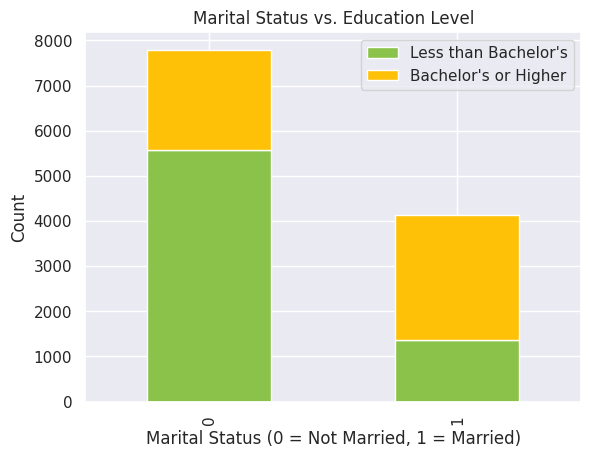

In [ ]:
# Calculating the contingency table and chi-square statistic
contingency_table = pd.crosstab(nhanes_data['DMDMARTZ'], nhanes_data['DMDEDUC2'])
chi2, p, dof, ex = chi2_contingency(contingency_table)

print(f"Chi2 Statistic: {chi2}, p-value: {p}")

# Plotting the contingency table with new colors
contingency_table.plot(kind="bar", stacked=True, color=["#8BC34A", "#FFC107"])
plt.title("Marital Status vs. Education Level")
plt.xlabel("Marital Status (0 = Not Married, 1 = Married)")
plt.ylabel("Count")
plt.legend(["Less than Bachelor's", "Bachelor's or Higher"])
plt.show()

## Question 2: Difference in Mean Sedentary Behavior Time Between Married and Not Married Individuals

T-Statistic: -3.8740971309213887, p-value: 0.0001078679819334709


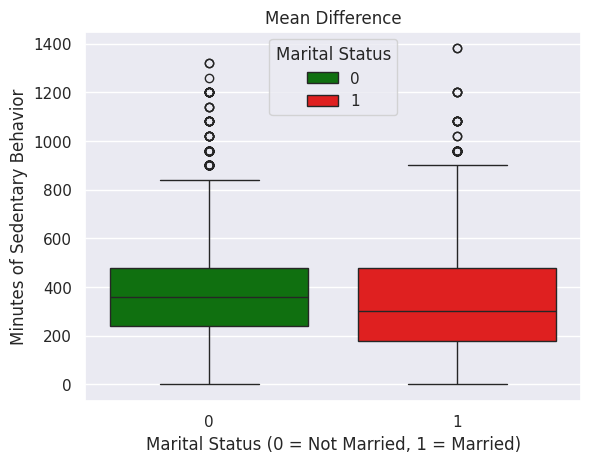

In [ ]:
# Filtering data for the t-test, separating married and not married groups based on 'DMDMARTZ' column
married = nhanes_data[nhanes_data['DMDMARTZ'] == 1]['PAD680'].dropna()
not_married = nhanes_data[nhanes_data['DMDMARTZ'] == 0]['PAD680'].dropna()

# Conducting an independent t-test to compare the mean sedentary behavior time between married and not married groups
t_stat, p_val = ttest_ind(married, not_married)

print(f"T-Statistic: {t_stat}, p-value: {p_val}")

sns.boxplot(x='DMDMARTZ', y='PAD680', data=nhanes_data,hue='DMDMARTZ', palette=['green', 'red'])
plt.xlabel('Marital Status (0 = Not Married, 1 = Married)')
plt.ylabel('Minutes of Sedentary Behavior')
plt.legend(title="Marital Status")
plt.title('Mean Difference')
plt.show()

## Question 3: Effect of Age and Marital Status on Systolic Blood Pressure

                   sum_sq      df            F    PR(>F)
C(DMDMARTZ)  1.737748e+03     1.0     6.860916  0.008828
RIDAGEYR     5.889160e+05     1.0  2325.138035  0.000000
Residual     1.893791e+06  7477.0          NaN       NaN


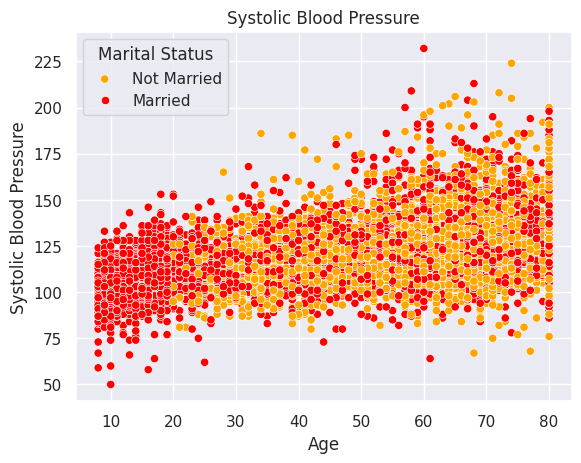

In [ ]:
 #Defining the OLS model with the correct 'data' argument
model = ols('BPXOSY3 ~ RIDAGEYR + C(DMDMARTZ)', data=nhanes_data).fit()

# Generating the ANOVA table
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

sns.scatterplot(x='RIDAGEYR', y='BPXOSY3', hue='DMDMARTZ', data=nhanes_data, palette=['red', 'orange'])
plt.title("Systolic Blood Pressure")
plt.xlabel("Age")
plt.ylabel("Systolic Blood Pressure")
plt.legend(title="Marital Status", labels=["Not Married", "Married"])
plt.show()

## Question 4: Correlation Between Self-Reported Weight and Minutes of Sedentary Behavior

Correlation: 0.1559714584645021, p-value: 1.6988498386828133e-44


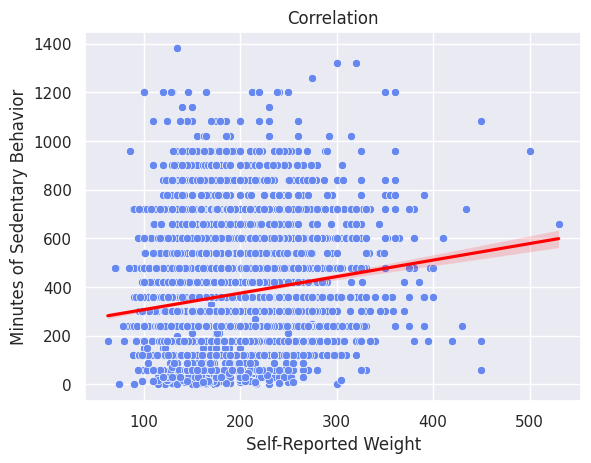

In [ ]:
subset_nhanes_data = nhanes_data[['WHD020', 'PAD680']].dropna()

# Performing Pearson correlation
correlation, p_value = pearsonr(subset_nhanes_data['WHD020'], subset_nhanes_data['PAD680'])
print(f"Correlation: {correlation}, p-value: {p_value}")

sns.scatterplot(x='WHD020', y='PAD680', data=nhanes_data)
sns.regplot(x='WHD020', y='PAD680', data=nhanes_data, scatter=False, color='red')
plt.xlabel("Self-Reported Weight")
plt.ylabel("Minutes of Sedentary Behavior")
plt.title("Correlation")
plt.show()

## Question 5 (Creative Analysis): Analysis of Education Level and Systolic Blood Pressure

For this analysis, I will examine whether there is a significant difference in systolic blood pressure (BPXOSY3) based on education level (DMDEDUC2).
The hypothesis is that individuals with a bachelor's degree or higher have a different mean systolic blood pressure compared to those with less than a bachelor's degree.

### Hypothesis
- **Null Hypothesis (H0):** There is no significant difference in the mean systolic blood pressure between individuals with a bachelor's degree or higher and those with less than a bachelor's degree.
- **Alternative Hypothesis (H1):** There is a significant difference in the mean systolic blood pressure between individuals with a bachelor's degree or higher and those with less than a bachelor's degree.

### Test Selection
An independent t-test is appropriate for this analysis because we are comparing the means of systolic blood pressure between two independent groups (education levels).


In [ ]:
# Import necessary libraries
from scipy.stats import ttest_ind

# Recode Education Level to two groups: Bachelor's or higher vs. Less than Bachelor's
nhanes_data['Education_Level'] = nhanes_data['DMDEDUC2'].apply(lambda x: 'Bachelor_or_Higher' if x >= 4 else 'Less_than_Bachelor')

# Drop any NaN values in systolic blood pressure and recoded education level for accurate testing
filtered_df = nhanes_data[['BPXOSY3', 'Education_Level']].dropna()

# Group systolic blood pressure data by education level
bp_bachelor_or_higher = filtered_df[filtered_df['Education_Level'] == 'Bachelor_or_Higher']['BPXOSY3']
bp_less_than_bachelor = filtered_df[filtered_df['Education_Level'] == 'Less_than_Bachelor']['BPXOSY3']

# Conduct independent t-test
t_stat, p_value = ttest_ind(bp_bachelor_or_higher, bp_less_than_bachelor)

# Output the t-statistic and p-value
print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("We reject the null hypothesis, indicating a significant difference in systolic blood pressure between the education levels.")
else:
    print("We fail to reject the null hypothesis, indicating no significant difference in systolic blood pressure between the education levels.")


T-statistic: nan, P-value: nan
We fail to reject the null hypothesis, indicating no significant difference in systolic blood pressure between the education levels.
